In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the data from dta

data = pd.read_stata('mydata.dta')
# lasso_control = pd.read_stata('lasso_control.dta')

# Preprocessing

In [17]:
import math
import warnings

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.stats
from scipy.stats import norm # edit
from scipy.special import log_ndtr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


def split_left_right_censored(x, y, cens):
    counts = cens.value_counts()
    if -1 not in counts and 1 not in counts:
        warnings.warn("No censored observations; use regression methods for uncensored data")
    xs = []
    ys = []

    for value in [-1, 0, 1]:
        if value in counts:
            split = cens == value
            y_split = np.squeeze(y[split].values)
            x_split = x[split].values

        else:
            y_split, x_split = None, None
        xs.append(x_split)
        ys.append(y_split)
    return xs, ys


def tobit_neg_log_likelihood(xs, ys, params):
    x_left, x_mid, x_right = xs
    y_left, y_mid, y_right = ys

    b = params[:-1]
    # s = math.exp(params[-1])
    s = params[-1]

    to_cat = []

    cens = False
    if y_left is not None:
        cens = True
        left = (y_left - np.dot(x_left, b))
        to_cat.append(left)
    if y_right is not None:
        cens = True
        right = (np.dot(x_right, b) - y_right)
        to_cat.append(right)
    if cens:
        concat_stats = np.concatenate(to_cat, axis=0) / s
        log_cum_norm = scipy.stats.norm.logcdf(concat_stats)  # log_ndtr(concat_stats)
        cens_sum = log_cum_norm.sum()
    else:
        cens_sum = 0

    if y_mid is not None:
        mid_stats = (y_mid - np.dot(x_mid, b)) / s
        mid = scipy.stats.norm.logpdf(mid_stats) - math.log(max(np.finfo('float').resolution, s))
        mid_sum = mid.sum()
    else:
        mid_sum = 0

    loglik = cens_sum + mid_sum

    return - loglik


def tobit_neg_log_likelihood_der(xs, ys, params):
    x_left, x_mid, x_right = xs
    y_left, y_mid, y_right = ys

    b = params[:-1]
    # s = math.exp(params[-1]) # in censReg, not using chain rule as below; they optimize in terms of log(s)
    s = params[-1]

    beta_jac = np.zeros(len(b))
    sigma_jac = 0

    if y_left is not None:
        left_stats = (y_left - np.dot(x_left, b)) / s
        l_pdf = scipy.stats.norm.logpdf(left_stats)
        l_cdf = log_ndtr(left_stats)
        left_frac = np.exp(l_pdf - l_cdf)
        beta_left = np.dot(left_frac, x_left / s)
        beta_jac -= beta_left

        left_sigma = np.dot(left_frac, left_stats)
        sigma_jac -= left_sigma

    if y_right is not None:
        right_stats = (np.dot(x_right, b) - y_right) / s
        r_pdf = scipy.stats.norm.logpdf(right_stats)
        r_cdf = log_ndtr(right_stats)
        right_frac = np.exp(r_pdf - r_cdf)
        beta_right = np.dot(right_frac, x_right / s)
        beta_jac += beta_right

        right_sigma = np.dot(right_frac, right_stats)
        sigma_jac -= right_sigma

    if y_mid is not None:
        mid_stats = (y_mid - np.dot(x_mid, b)) / s
        beta_mid = np.dot(mid_stats, x_mid / s)
        beta_jac += beta_mid

        mid_sigma = (np.square(mid_stats) - 1).sum()
        sigma_jac += mid_sigma

    combo_jac = np.append(beta_jac, sigma_jac / s)  # by chain rule, since the expression above is dloglik/dlogsigma

    return -combo_jac


class TobitModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.ols_coef_ = None
        self.ols_intercept = None
        self.coef_ = None
        self.intercept_ = None
        self.sigma_ = None

    def fit(self, x, y, cens, verbose=False):
        """
        Fit a maximum-likelihood Tobit regression
        :param x: Pandas DataFrame (n_samples, n_features): Data
        :param y: Pandas Series (n_samples,): Target
        :param cens: Pandas Series (n_samples,): -1 indicates left-censored samples, 0 for uncensored, 1 for right-censored
        :param verbose: boolean, show info from minimization
        :return:
        """
        x_copy = x.copy()
        if self.fit_intercept:
            x_copy.insert(0, 'intercept', 1.0)
        else:
            x_copy.scale(with_mean=True, with_std=False, copy=False)
        init_reg = LinearRegression(fit_intercept=False).fit(x_copy, y)
        b0 = init_reg.coef_
        y_pred = init_reg.predict(x_copy)
        resid = y - y_pred
        resid_var = np.var(resid)
        s0 = np.sqrt(resid_var)
        params0 = np.append(b0, s0)
        xs, ys = split_left_right_censored(x_copy, y, cens)

        result = minimize(lambda params: tobit_neg_log_likelihood(xs, ys, params), params0, method='BFGS',
                          jac=lambda params: tobit_neg_log_likelihood_der(xs, ys, params), options={'disp': verbose})
        if verbose:
            print(result)
        self.ols_coef_ = b0[1:]
        self.ols_intercept = b0[0]
        if self.fit_intercept:
            self.intercept_ = result.x[1]
            self.coef_ = result.x[1:-1]
        else:
            self.coef_ = result.x[:-1]
            self.intercept_ = 0
        self.sigma_ = result.x[-1]
        return self

    def predict(self, x):
        return self.intercept_ + np.dot(x, self.coef_)

    def score(self, x, y, scoring_function=mean_absolute_error):
        y_pred = np.dot(x, self.coef_)
        return scoring_function(y, y_pred)

    # EDIT - insert marginal effects function
    def margins(self, x, k = 0): 
        """
        Marginal effects on dependent variable of a regressor, identified by coef
        :param x: array with all regressors (independent variables) to make a prediction
        :param k: coefficient corresponding to the regressor with respect to which we want to take the marginal effects
        :return: an array with the marginal effects estimated at each observation's level

        The marginal effect of regressor k on individual i's y is defined as the product of coef[k] and the normal cdf 
        evaluated at x_i * coeff[k] / sigma
        """
        return self.coef_[k] * norm.cdf(self.predict(x) / self.sigma_)

In [18]:
lasso_control = ['b_c1',
 'b_c2',
 'b_num_rightage',
 'b_village_id_1',
 'b_village_id_2',
 'b_village_id_3',
 'b_village_id_4',
 'b_village_id_5',
 'b_village_id_6',
 'b_village_id_7',
 'b_village_id_8',
 'b_village_id_9',
 'b_village_id_10',
 'b_village_id_11',
 'b_village_id_12',
 'b_village_id_13',
 'b_village_id_14',
 'b_village_id_15',
 'b_village_id_16',
 'b_fo_id_1',
 'b_fo_id_2',
 'b_fo_id_3',
 'b_fo_id_4',
 'b_fo_id_5',
 'b_fo_id_6',
 'b_fo_id_7',
 'b_fo_id_8',
 'b_fo_id_9',
 'e_fo_id_1',
 'e_fo_id_2',
 'e_fo_id_3',
 'e_fo_id_4',
 'e_fo_id_5',
 'e_fo_id_6',
 'e_fo_id_7',
 'e_fo_id_8',
 'e_fo_id_9',
 'e_fo_id_10',
 'e_fo_id_11',
 'b_f_head_age',
 'b_m_head_age',
 'b_no_male_head',
 'b_no_female_head',
 'b_f_head_gone',
 'b_m_head_gone',
 'b_f_head_edu',
 'b_m_head_edu',
 'b_f_head_earned',
 'b_m_head_earned',
 'b_f_head_primary',
 'b_m_head_primary',
 'b_f_head_secondary',
 'b_m_head_secondary',
 'b_f_head_earnings',
 'b_m_head_earnings',
 'b_head_migrated_n',
 'b_anyone_migrated_n',
 'b_head_migrated_k',
 'b_anyone_migrated_k',
 'b_head_migrated_e',
 'b_anyone_migrated_e',
 'b_migrant_in_n',
 'b_migrant_in_e',
 'b_migrant_in_k',
 'b_saved_30',
 'b_savings_30',
 'b_hh_income',
 'b_hh_income_n',
 'b_hh_income_mig',
 'b_hh_income_mig_temp',
 'b_hh_income_n_temp',
 'b_employed_num',
 'b_mig_employed_num',
 'b_n_employed_num',
 'b_mig_temp_employed_num',
 'b_n_temp_employed_num']

In [19]:
dummy = data[['hh_id','period']]
treat = data[['treatment']]
outcome = data[['income_tot','income_n','remit','savings','food','healthy_finance','happy']]
cont = data[['income_tot_cont','income_n_cont','remit_cont','savings_cont','food_cont','healthy_finance_cont','happy_cont']]
# rest are controls
controls = data[lasso_control]


# Experiment with lasso

In [20]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

# Assuming outcome and controls are already defined
temp_dat = pd.concat([outcome['income_tot'], controls], axis=1)
# temp_dat = temp_dat.dropna(subset=['income_tot'])
# temp_dat = temp_dat.fillna(temp_dat.mean())
temp_dat = temp_dat.dropna()

# Convert datetime columns to numerical or drop them
for col in temp_dat.columns:
    if pd.api.types.is_datetime64_any_dtype(temp_dat[col]):
        # Example: Convert datetime to timestamp
        temp_dat[col] = temp_dat[col].apply(lambda x: x.timestamp())

X = temp_dat[controls.columns]
y = temp_dat['income_tot']

# Ensure all columns in X are numerical
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any remaining non-numerical columns
X = X.dropna(axis=1, how='any')

# Fit Lasso model
lasso = Lasso()
lasso.fit(X, y)

# Get the selected variables
selected_vars = X.columns[lasso.coef_ != 0]
print(selected_vars)

Index(['b_c1', 'b_c2', 'b_num_rightage', 'b_village_id_2', 'b_village_id_10',
       'b_village_id_13', 'b_village_id_15', 'b_fo_id_1', 'b_fo_id_3',
       'b_fo_id_5', 'b_fo_id_7', 'e_fo_id_2', 'e_fo_id_3', 'e_fo_id_6',
       'e_fo_id_8', 'e_fo_id_10', 'e_fo_id_11', 'b_f_head_age', 'b_m_head_age',
       'b_no_male_head', 'b_m_head_gone', 'b_f_head_edu', 'b_m_head_edu',
       'b_f_head_earned', 'b_m_head_primary', 'b_m_head_secondary',
       'b_f_head_earnings', 'b_m_head_earnings', 'b_anyone_migrated_n',
       'b_anyone_migrated_k', 'b_migrant_in_e', 'b_saved_30', 'b_savings_30',
       'b_hh_income', 'b_hh_income_n', 'b_hh_income_mig',
       'b_hh_income_mig_temp', 'b_hh_income_n_temp', 'b_employed_num',
       'b_mig_temp_employed_num'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

# Assuming outcome and controls are already defined
temp_dat = pd.concat([outcome['income_tot'], controls], axis=1)
temp_dat = temp_dat.dropna()

# Convert datetime columns to numerical or drop them
for col in temp_dat.columns:
    if pd.api.types.is_datetime64_any_dtype(temp_dat[col]):
        # Convert datetime to timestamp
        temp_dat[col] = temp_dat[col].apply(lambda x: x.timestamp())

X = temp_dat[controls.columns]
y = temp_dat['income_tot']

# Ensure all columns in X are numerical
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any remaining non-numerical columns
X = X.dropna(axis=1, how='any')

alphas = np.logspace(-10, 10, 10)
scores = []
for alpha in alphas:
    clf = Lasso(alpha=alpha, max_iter=10000)
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=10000)
lasso.fit(X, y)

# get the selected variables
selected_vars = X.columns[lasso.coef_ != 0]
print(selected_vars)

In [ ]:
# import lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

temp_dat = pd.concat([outcome['income_tot'], controls], axis=1)
temp_dat = temp_dat.dropna(subset=['income_tot'])

# impute missing values by mean
temp_dat = temp_dat.fillna(temp_dat.mean())

X = temp_dat[controls.columns]
y = temp_dat['income_tot']

alphas = np.logspace(-20, 20, 100)
scores = []
for alpha in alphas:
    clf = Lasso(alpha=alpha, max_iter=10000)
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=100000)
lasso.fit(X, y).coef_

# get the selected variables
selected_vars = X.columns[lasso.coef_ != 0]
selected_vars

In [51]:
lasso.fit(X, y).coef_

array([ 2.23461621e+01,  0.00000000e+00,  1.24212157e+01,  2.28410230e+01,
        6.32667479e-03,  6.12851608e-01,  1.94894063e-01,  3.08380052e+01,
        6.52827905e-01, -7.72331475e+00, -2.79716473e+01])

In [7]:
temp_dat

,treatment,b_c1,b_c2,b_num_rightage,b_date,b_village_id_1,b_village_id_2,b_village_id_3,b_village_id_4,b_village_id_5,...,b_hh_income,b_hh_income_n,b_hh_income_mig,b_hh_income_mig_temp,b_hh_income_n_temp,b_employed_num,b_mig_employed_num,b_n_employed_num,b_mig_temp_employed_num,b_n_temp_employed_num
0,0,0,3,1,1.484698e+09,0,0,1,0,0,...,93.457947,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0
1,0,0,3,1,1.484698e+09,0,0,1,0,0,...,93.457947,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0
2,0,1,4,1,1.485389e+09,0,0,0,0,0,...,0.000000,0.000000,0.000000,56.074768,0.000000,0,0,0,1,0
3,0,1,4,1,1.485389e+09,0,0,0,0,0,...,0.000000,0.000000,0.000000,56.074768,0.000000,0,0,0,1,0
4,0,0,3,2,1.485821e+09,0,0,0,0,0,...,100.700935,0.000000,79.439255,60.747665,60.747665,3,1,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,1,2,0,2,1.485216e+09,0,0,0,0,0,...,0.000000,0.000000,0.000000,46.728973,46.728973,0,0,0,1,1
990,0,1,4,1,1.486426e+09,0,0,0,0,0,...,96.261681,93.457947,93.457947,0.000000,0.000000,2,1,1,0,0
991,0,1,4,1,1.486426e+09,0,0,0,0,0,...,96.261681,93.457947,93.457947,0.000000,0.000000,2,1,1,0,0
992,1,2,4,1,1.485216e+09,0,0,0,0,0,...,102.803741,0.000000,37.383179,58.878506,0.000000,2,1,0,2,0


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
temp_dat = pd.concat([treat,controls], axis=1)
temp_dat = temp_dat.dropna()

# Convert datetime columns to numerical or drop them
for col in temp_dat.columns:
    if pd.api.types.is_datetime64_any_dtype(temp_dat[col]):
        # Convert datetime to timestamp
        temp_dat[col] = temp_dat[col].apply(lambda x: x.timestamp())

X = temp_dat[controls.columns]
y = temp_dat[treat.columns].values.ravel()

# Ensure all columns in X are numerical
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any remaining non-numerical columns
X = X.dropna(axis=1, how='any')


alphas = np.logspace(-10, 10, 100)
scores = []
for alpha in alphas:
    clf = LogisticRegression(C=alpha, max_iter=1000, penalty='l1', solver='liblinear')
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
alpha = alphas[np.argmax(scores)]


# fit lasso
lasso = LogisticRegression(C=alpha, max_iter=1000, penalty='l1', solver='liblinear')
lasso.fit(X, y).coef_

# get the selected variables
selected_vars = X.columns[lasso.coef_.ravel() != 0]
selected_vars

Index(['b_hh_income', 'b_hh_income_mig_temp'], dtype='object')

In [253]:
# import ols 
import statsmodels.formula.api as smf

temp_dat = pd.concat([outcome['income_tot'], controls[selected_vars], treat, dummy,cont], axis=1)
temp_dat = temp_dat.dropna()

# X = temp_dat.drop('income_tot', axis=1)
# y = temp_dat['income_tot']

reg_cl = smf.ols(formula='income_tot ~ 1 + treatment + C(period) + migration_n_cumul + worried2 + b_remittances + b_savings_30 + b_hh_income_n + income_tot_cont', data=temp_dat).fit(cov_type='cluster', cov_kwds={'groups': temp_dat['hh_id']})
reg_cl.summary()

c:\Users\huang\anaconda3\Lib\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             income_tot   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     10.22
Date:                Sat, 13 Jul 2024   Prob (F-statistic):           7.12e-12
Time:                        07:56:30   Log-Likelihood:                -5591.0
No. Observations:                 869   AIC:                         1.120e+04
Df Residuals:                     861   BIC:                         1.124e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           115.3617     10.612     10.871      0.000      94.563     136.160
C(period)[T.2]        2.2997      8.190      0.281      0.779     -13.752      18.351
treatment            32.9141     11.848      2.778      0.005       9.693      56.136
migration_n_cumul    24.0722      9.142      2.633      0.008       6.154      41.990
worried2            -26.6262     11.852     -2.247      0.025     -49.855      -3.397
b_remittances         0.0064      0.003      1.949      0.051   -3.47e-05       0.013
b_savings_30          0.3666      0.168      2.182      0.029       0.037       0.696
b_hh_income_n         0.3506      0.093      3.781      0.000       0.169       0.532
income_tot_cont       0.3506      0.093      3.781      0.000       0.169       0.532
==============================================================================
Omnibus:                      269.992   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              857.253
Skew:                           1.512   Prob(JB):                    7.08e-187
Kurtosis:                       6.812   Cond. No.                     8.28e+17
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 4.08e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [254]:
# import ols 
import statsmodels.formula.api as smf

temp_dat = pd.concat([outcome['income_tot'], controls[selected_vars], treat, dummy,cont], axis=1)
temp_dat = temp_dat.dropna()

# X = temp_dat.drop('income_tot', axis=1)
# y = temp_dat['income_tot']

reg_cl = smf.ols(formula='income_tot ~ 1 + treatment + C(period) + worried2 + migration_n_cumul + b_remittances + b_savings_30 + b_hh_income_n + income_tot_cont + income_n_cont + remit_cont + savings_cont + food_cont + healthy_finance_cont + happy_cont', data=temp_dat).fit(cov_type='cluster', cov_kwds={'groups': temp_dat['hh_id']})
reg_cl.summary()

# get the coefficient, standard error, and p-value of treatment
reg_cl.params['treatment'], reg_cl.bse['treatment'], reg_cl.pvalues['treatment']

c:\Users\huang\anaconda3\Lib\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 10
  warnings.warn('covariance of constraints does not have full '


(32.823678785305646, 11.894946491910526, 0.0057896233532088144)

In [73]:
outcome.columns[0]

'income_tot'

## Tab3 Replication - No imputation

In [268]:
tab3_no = pd.DataFrame()

for i in outcome.columns:
    temp_dat = pd.concat([outcome[i], controls], axis=1)
    temp_dat = temp_dat.dropna()

    X = temp_dat[controls.columns]
    y = temp_dat[i]
    # standardize the data
    scaler = StandardScaler()
    # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    # y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)), columns=[i])


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = Lasso(alpha=alpha, max_iter=10000)
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

    # get the selected variables
    selected_vars1 = X.columns[lasso.coef_ != 0]

    # second lasso

    temp_dat = pd.concat([treat,controls], axis=1)
    temp_dat = temp_dat.dropna()

    X = temp_dat[controls.columns]
    y = temp_dat[treat.columns].values.ravel()

    # standardize the data
    scaler = StandardScaler()
    # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = LogisticRegression(C=alpha, max_iter=10000, penalty='l1', solver='liblinear')
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

    # get the selected variables
    selected_vars2 = X.columns[lasso.coef_ != 0]

    # take the union of the two sets of selected variables
    selected_vars = np.union1d(selected_vars1, selected_vars2)

    temp_dat = pd.concat([outcome[i], controls[selected_vars], treat, dummy,cont], axis=1)
    temp_dat = temp_dat.dropna()

    # X = temp_dat.drop('income_tot', axis=1)
    # y = temp_dat['income_tot']

    formula = f'{i} ~ 1 + treatment + C(period) + ' + ' + '.join(selected_vars) + '+' + ' + '.join(cont.columns)

    reg_cl = smf.ols(formula=formula, data=temp_dat).fit(cov_type='cluster', cov_kwds={'groups': temp_dat['hh_id']})
    reg_cl.summary()

    # get the coefficient, standard error, and p-value of treatment
    tab3_no = pd.concat([tab3_no, pd.DataFrame({'coef': reg_cl.params['treatment'], 'se': reg_cl.bse['treatment'], 'pval': reg_cl.pvalues['treatment'], 'Control Mean': temp_dat[temp_dat['treatment']==0][i].mean() ,'N':reg_cl.nobs}, index=[i])])

In [269]:
tab3_no

,coef,se,pval,Control Mean,N
income_tot,32.823679,11.894946,0.005790,140.944901,869.0
income_n,30.128598,16.320544,0.064884,20.478872,939.0
remit,2.037724,2.158117,0.345060,9.961748,861.0
savings,2.077782,2.116471,0.326238,11.843745,850.0
food,2.108558,1.763854,0.231920,36.206863,861.0
healthy_finance,0.000227,0.002267,0.920328,0.554245,850.0
happy,0.169654,0.099799,0.089138,0.013805,424.0


In [30]:
import warnings
warnings.filterwarnings('ignore')
# import lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
# import logit
from sklearn.linear_model import LogisticRegression
# import ols
import statsmodels.formula.api as smf

tab3_var = pd.DataFrame()

for i in outcome.columns[:1]:
    temp_dat = pd.concat([outcome[i], controls], axis=1)
    temp_dat = temp_dat.dropna()
    # impute missing values by median
    # temp_dat = temp_dat.fillna(temp_dat.mean())

    X = temp_dat[controls.columns]
    y = temp_dat[i]
    # standardize the data
    scaler = StandardScaler()
    # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    # y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)), columns=[i])


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = Lasso(alpha=alpha, max_iter=10000)
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

    # get the selected variables
    selected_vars1 = X.columns[lasso.coef_ != 0]

    # second lasso

    temp_dat = pd.concat([treat,controls], axis=1)
    temp_dat = temp_dat.dropna()
    # impute missing values by median
    # temp_dat = temp_dat.fillna(temp_dat.mean())

    X = temp_dat[controls.columns]
    y = temp_dat[treat.columns].values.ravel()

    # standardize the data
    scaler = StandardScaler()
    # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = LogisticRegression(C=alpha, max_iter=10000, penalty='l1', solver='liblinear')
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

    # get the selected variables
    selected_vars2 = X.columns[lasso.coef_ != 0]

    # take the union of the two sets of selected variables
    selected_vars = np.union1d(selected_vars1, selected_vars2)
    tab3_var_temp = pd.concat([tab3_var, pd.DataFrame({'outcome_control':str(list(selected_vars1)), 'treat_control':str(list(selected_vars2))}, index=[i])])


In [31]:
tab3_var_temp

,outcome_control,treat_control
income_tot,"['b_hh_income', 'b_hh_income_mig']","['b_c1', 'b_c2', 'b_num_rightage', 'b_village_id_1', 'b_village_id_2', 'b_village_id_4', 'b_village_id_5', 'b_village_id_6', 'b_village_id_7', 'b_village_id_10', 'b_village_id_11', 'b_village_id_12', 'b_village_id_13', 'b_village_id_14', 'b_village_id_15', 'b_fo_id_1', 'b_fo_id_2', 'b_fo_id_3', 'b_fo_id_4', 'b_fo_id_5', 'b_fo_id_9', 'e_fo_id_2', 'e_fo_id_3', 'e_fo_id_4', 'e_fo_id_5', 'e_fo_id_6', 'e_fo_id_8', 'e_fo_id_9', 'e_fo_id_10', 'e_fo_id_11', 'b_f_head_age', 'b_m_head_age', 'b_no_male_head', 'b_f_head_gone', 'b_m_head_gone', 'b_f_head_edu', 'b_m_head_edu', 'b_f_head_earned', 'b_m_head_earned', 'b_f_head_primary', 'b_m_head_secondary', 'b_f_head_earnings', 'b_m_head_earnings', 'b_head_migrated_n', 'b_anyone_migrated_n', 'b_head_migrated_k', 'b_anyone_migrated_k', 'b_head_migrated_e', 'b_anyone_migrated_e', 'b_migrant_in_n', 'b_migrant_in_e', 'b_migrant_in_k', 'b_savings_30', 'b_hh_income', 'b_hh_income_n', 'b_hh_income_mig', 'b_hh_income_mig_temp', 'b_hh_income_n_temp', 'b_employed_num', 'b_mig_employed_num', 'b_mig_temp_employed_num', 'b_n_temp_employed_num']"


In [50]:
import warnings
warnings.filterwarnings('ignore')
# import lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
# import logit
from sklearn.linear_model import LogisticRegression
# import ols
import statsmodels.formula.api as smf

tab3_var = pd.DataFrame()

for i in outcome.columns:
    temp_dat = pd.concat([outcome[i], controls], axis=1)
    temp_dat = temp_dat.dropna()
    # impute missing values by median
    temp_dat = temp_dat.fillna(temp_dat.mean())

    X = temp_dat[controls.columns]
    y = temp_dat[i]
    # standardize the data
    scaler = StandardScaler()
    # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    # y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)), columns=[i])


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = Lasso(alpha=alpha, max_iter=10000)
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

    # get the selected variables
    selected_vars1 = X.columns[lasso.coef_ != 0]

    # second lasso

    temp_dat = pd.concat([treat,controls], axis=1)
    temp_dat = temp_dat.dropna()
    # impute missing values by median
    # temp_dat = temp_dat.fillna(temp_dat.mean())

    X = temp_dat[controls.columns]
    y = temp_dat[treat.columns].values.ravel()

    # standardize the data
    scaler = StandardScaler()
    # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = LogisticRegression(C=alpha, max_iter=10000, penalty='l1', solver='liblinear')
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = LogisticRegression(C=alpha, max_iter=1000, penalty='l1', solver='liblinear').fit(X, y)

    # get the selected variables
    selected_vars2 = X.columns[lasso.coef_.ravel() != 0]

    # take the union of the two sets of selected variables
    selected_vars = np.union1d(selected_vars1, selected_vars2)
    tab3_var = pd.concat([tab3_var, pd.DataFrame({'outcome_control':str(list(selected_vars1)), 'treat_control':str(list(selected_vars2))}, index=[i])])
    print(i)


income_tot
income_n
remit
savings
food
healthy_finance
happy


In [51]:
# show full length of string
pd.set_option('display.max_colwidth', None)
tab3_var

,outcome_control,treat_control
income_tot,"['b_hh_income', 'b_hh_income_mig']","['b_hh_income', 'b_hh_income_mig_temp']"
income_n,"['b_m_head_earnings', 'b_hh_income_n', 'b_hh_income_mig']","['b_hh_income', 'b_hh_income_mig_temp']"
remit,"['b_hh_income', 'b_hh_income_mig']","['b_hh_income', 'b_hh_income_mig_temp']"
savings,['b_hh_income'],"['b_hh_income', 'b_hh_income_mig_temp']"
food,"['b_m_head_earnings', 'b_savings_30', 'b_hh_income', 'b_hh_income_n', 'b_hh_income_mig', 'b_hh_income_mig_temp', 'b_hh_income_n_temp']","['b_hh_income', 'b_hh_income_mig_temp']"
healthy_finance,"['b_c2', 'e_fo_id_11', 'b_f_head_age', 'b_m_head_age', 'b_f_head_edu', 'b_m_head_edu', 'b_f_head_earned', 'b_f_head_earnings', 'b_m_head_earnings', 'b_savings_30', 'b_hh_income', 'b_hh_income_n', 'b_hh_income_mig', 'b_hh_income_mig_temp', 'b_hh_income_n_temp']","['b_hh_income', 'b_hh_income_mig_temp']"
happy,"['b_m_head_earnings', 'b_savings_30', 'b_hh_income_n_temp']","['b_hh_income', 'b_hh_income_mig_temp']"


## Tab3 Replication

In [23]:
import warnings
warnings.filterwarnings('ignore')
# import lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
# import logit
from sklearn.linear_model import LogisticRegression
# import ols
import statsmodels.formula.api as smf

tab3 = pd.DataFrame()

for i in outcome.columns:
    temp_dat = pd.concat([outcome[i], controls], axis=1)
    temp_dat = temp_dat.dropna(subset=[i])
    # impute missing values by median
    temp_dat = temp_dat.fillna(temp_dat.mean())

    X = temp_dat[controls.columns]
    y = temp_dat[i]
    # standardize the data
    scaler = StandardScaler()
    # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    # y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)), columns=[i])


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = Lasso(alpha=alpha, max_iter=10000)
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

    # get the selected variables
    selected_vars1 = X.columns[lasso.coef_ != 0]

    # second lasso

    temp_dat = pd.concat([treat,controls], axis=1)
    temp_dat = temp_dat.dropna(subset=['treatment'])
    # impute missing values by median
    temp_dat = temp_dat.fillna(temp_dat.mean())

    X = temp_dat[controls.columns]
    y = temp_dat[treat.columns].values.ravel()

    # standardize the data
    scaler = StandardScaler()
    # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = LogisticRegression(C=alpha, max_iter=10000, penalty='l1', solver='liblinear')
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = LogisticRegression(C=alpha, max_iter=1000, penalty='l1', solver='liblinear').fit(X, y)

    # get the selected variables
    selected_vars2 = X.columns[lasso.coef_ !.ravel()= 0]

    # take the union of the two sets of selected variables
    selected_vars = np.union1d(selected_vars1, selected_vars2)

    temp_dat = pd.concat([outcome[i], controls[selected_vars], treat, dummy,cont], axis=1)
    temp_dat = temp_dat.dropna(subset=[i])
    # impute missing values by median
    temp_dat = temp_dat.fillna(temp_dat.mean())

    # X = temp_dat.drop('income_tot', axis=1)
    # y = temp_dat['income_tot']

    formula = f'{i} ~ 1 + treatment + C(period) + ' + ' + '.join(selected_vars) + '+' + ' + '.join(cont.filter(like=i).columns)

    reg_cl = smf.ols(formula=formula, data=temp_dat).fit(cov_type='cluster', cov_kwds={'groups': temp_dat['hh_id']})
    reg_cl.summary()

    # get the coefficient, standard error, and p-value of treatment
    tab3 = pd.concat([tab3, pd.DataFrame({'coef': reg_cl.params['treatment'], 'se': reg_cl.bse['treatment'], 'pval': reg_cl.pvalues['treatment'], 'Control Mean': temp_dat[temp_dat['treatment']==0][i].mean() ,'N':reg_cl.nobs}, index=[i])])

c:\Users\huang\anaconda3\Lib\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 65, but rank is 64
  warnings.warn('covariance of constraints does not have full '
c:\Users\huang\anaconda3\Lib\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 65, but rank is 64
  warnings.warn('covariance of constraints does not have full '
c:\Users\huang\anaconda3\Lib\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 65, but rank is 64
  warnings.warn('covariance of constraints does not have full '


In [60]:
import ast
ast.literal_eval(tab3_var.loc['income_tot', 'outcome_control'])


['b_hh_income', 'b_hh_income_mig']

In [61]:
import warnings
import ast
warnings.filterwarnings('ignore')
# import lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
# import logit
from sklearn.linear_model import LogisticRegression
# import ols
import statsmodels.formula.api as smf

tab3 = pd.DataFrame()

for i in outcome.columns:

    # take the union of treated and control variables in tab_var
    selected_vars1 = ast.literal_eval(tab3_var.loc[i, 'outcome_control'])
    selected_vars2 = ast.literal_eval(tab3_var.loc[i, 'treat_control'])
    selected_vars = np.union1d(selected_vars1, selected_vars2)

    temp_dat = pd.concat([outcome[i], controls[selected_vars], treat, dummy,cont], axis=1)
    temp_dat = temp_dat.dropna(subset=[i])
    # impute missing values by median
    temp_dat = temp_dat.fillna(temp_dat.mean())

    # X = temp_dat.drop('income_tot', axis=1)
    # y = temp_dat['income_tot']

    formula = f'{i} ~ 1 + treatment + C(period) + ' + ' + '.join(selected_vars) + '+' + ' + '.join(cont.filter(like=i).columns)

    reg_cl = smf.ols(formula=formula, data=temp_dat).fit(cov_type='cluster', cov_kwds={'groups': temp_dat['hh_id']})
    reg_cl.summary()

    # get the coefficient, standard error, and p-value of treatment
    tab3 = pd.concat([tab3, pd.DataFrame({'coef': reg_cl.params['treatment'], 'se': reg_cl.bse['treatment'], 'pval': reg_cl.pvalues['treatment'], 'Control Mean': temp_dat[temp_dat['treatment']==0][i].mean() ,'N':reg_cl.nobs}, index=[i])])

In [28]:
tab3.round(3)

,coef,se,pval,Control Mean,N
income_tot,29.404,11.364,0.010,139.951,939.0
income_n,25.189,16.449,0.126,20.479,939.0
remit,1.718,2.092,0.412,10.001,896.0
savings,1.558,2.060,0.449,12.353,896.0
food,2.226,1.718,0.195,35.836,896.0
healthy_finance,0.001,0.004,0.797,0.546,896.0
happy,0.184,0.097,0.058,-0.000,435.0


In [9]:
tab3['Control Mean']
# keep 3 decimal places
tab3['Control Mean'] = tab3['Control Mean'].apply(lambda x: round(x, 3))
tab3['Control Mean']

income_tot         139.951
income_n            20.479
remit               10.001
savings             12.353
food                35.836
healthy_finance      0.546
happy               -0.000
Name: Control Mean, dtype: float64

In [27]:
tab3_rpl = tab3.round(2)
tab3_rpl.to_latex('tab3_rpl.tex')

# Tobit

In [17]:
y = data['income_tot']
x = data.drop(['income_tot'], axis=1)
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts(normalize=True)

 0.0    0.984909
-1.0    0.015091
dtype: float64

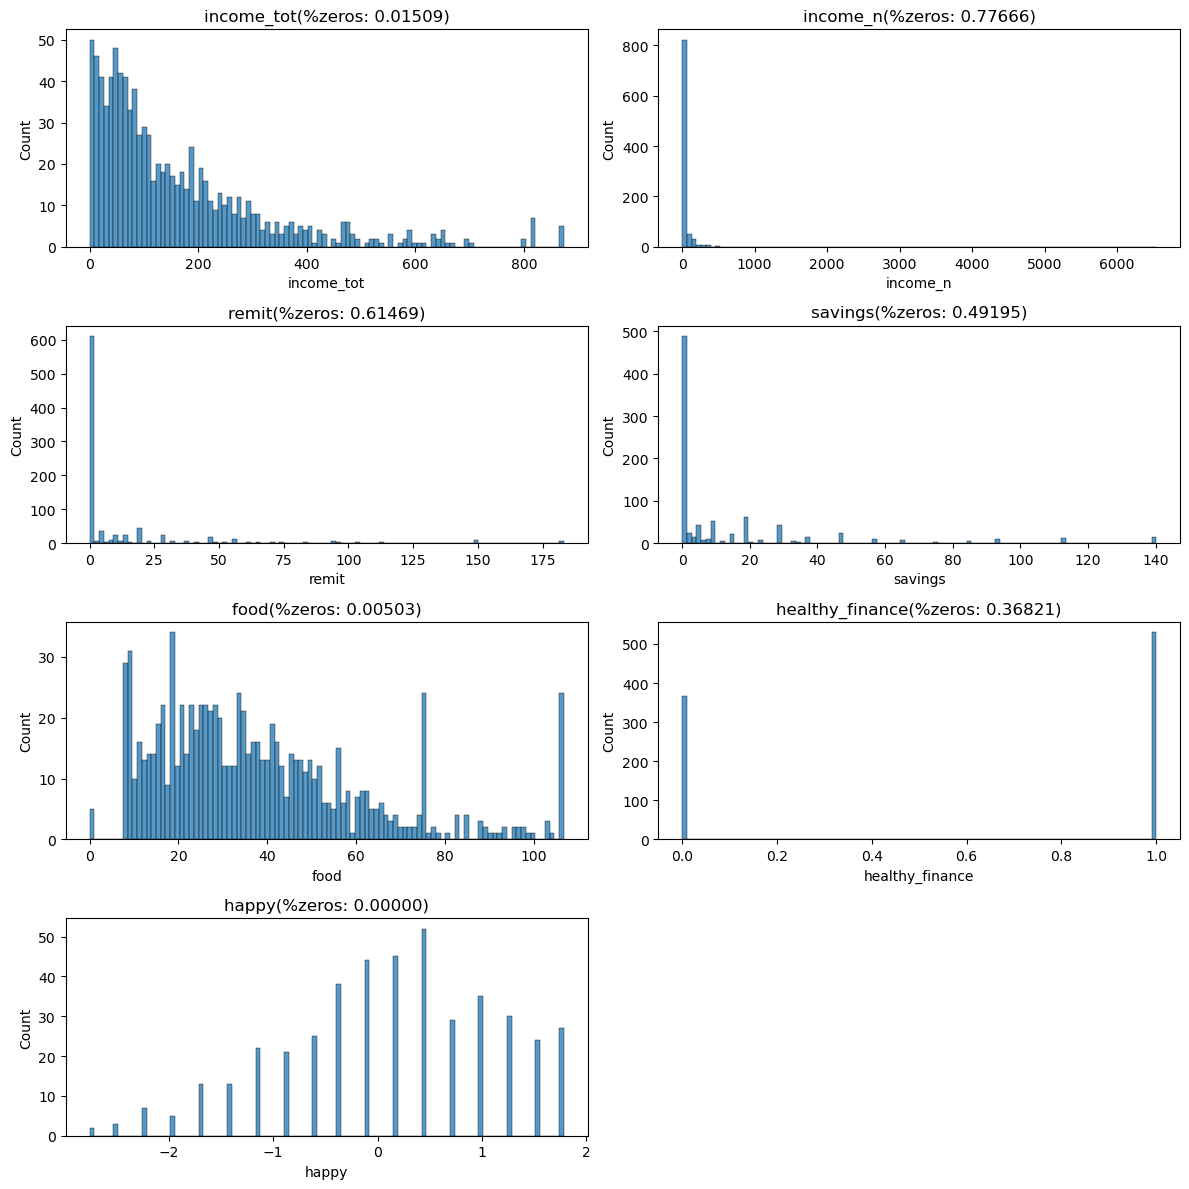

In [28]:
# show the distribution of all outcomes
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.ravel()
for i, ax in enumerate(axes):
    if i < len(outcome.columns):
        sns.histplot(data[outcome.columns[i]], ax=ax, bins=100)
        # set the title as the name of the variable and the proportion of 0 values
        y = data[outcome.columns[i]]
        cens = pd.Series(np.zeros(len(y)))
        cens[y==0] = -1
        ax.set_title(f'{outcome.columns[i]}(%zeros: {cens.value_counts(normalize=True).get(-1, 0):.5f})')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

# save the figure
fig.savefig('outcome_dist.png')



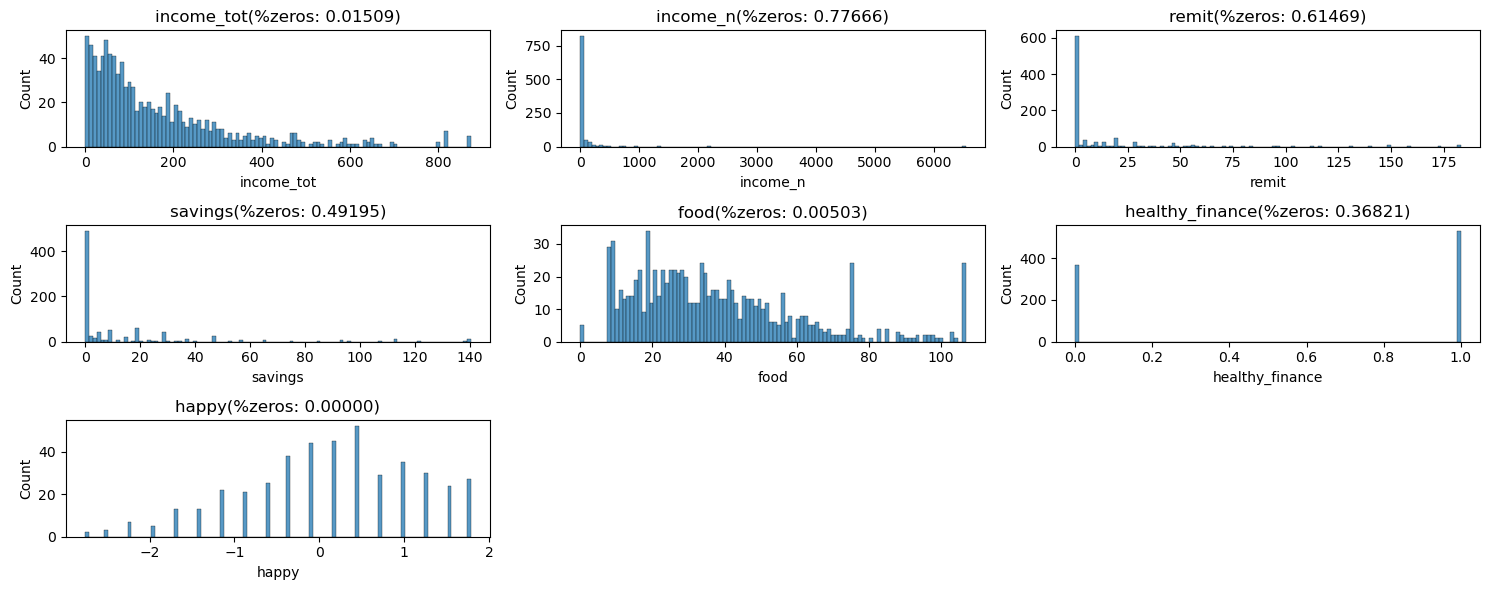

In [51]:
# change the plot into a 2-3-2 layout
fig, axes = plt.subplots(3, 3, figsize=(15, 6))
axes = axes.ravel()

for i, ax in enumerate(axes):
    if i < len(outcome.columns):
        sns.histplot(data[outcome.columns[i]], ax=ax, bins=100)
        # set the title as the name of the variable and the proportion of 0 values
        y = data[outcome.columns[i]]
        cens = pd.Series(np.zeros(len(y)))
        cens[y==0] = -1
        ax.set_title(f'{outcome.columns[i]}(%zeros: {cens.value_counts(normalize=True).get(-1, 0):.5f})')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


In [5]:
y = data['income_tot']
x = data.drop(['income_tot'], axis=1)
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts(normalize=True)

 0.0    0.984909
-1.0    0.015091
dtype: float64

In [125]:
outcome.columns

Index(['income_tot', 'income_n', 'remit', 'savings', 'food', 'healthy_finance',
       'happy'],
      dtype='object')

In [6]:
y = data['income_n']
x = data[controls.columns]
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts(normalize=True)

-1.0    0.77666
 0.0    0.22334
dtype: float64

In [7]:
y = data['remit']
x = data[controls.columns]
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts(normalize=True)

-1.0    0.614688
 0.0    0.385312
dtype: float64

In [8]:
y = data['savings']
x = data[controls.columns]
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts(normalize=True)

 0.0    0.508048
-1.0    0.491952
dtype: float64

## income_tot

In [240]:
i = 'income_tot'

temp_dat = pd.concat([outcome[i], controls], axis=1)
temp_dat = temp_dat.dropna(subset=[i])
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

X = temp_dat[controls.columns]
y = temp_dat[i]
# standardize the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)), columns=[i])


alphas = np.logspace(-10, 10, 100)
scores = []
for alpha in alphas:
    clf = Lasso(alpha=alpha, max_iter=10000)
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

# get the selected variables
selected_vars1 = X.columns[lasso.coef_ != 0]

# second lasso

temp_dat = pd.concat([treat,controls], axis=1)
temp_dat = temp_dat.dropna(subset=['treatment'])
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

X = temp_dat[controls.columns]
y = temp_dat[treat.columns].values.ravel()

# standardize the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


alphas = np.logspace(-10, 10, 100)
scores = []
for alpha in alphas:
    clf = LogisticRegression(C=alpha, max_iter=10000, penalty='l1', solver='liblinear')
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

# get the selected variables
selected_vars2 = X.columns[lasso.coef_ != 0]

# take the union of the two sets of selected variables
selected_vars = np.union1d(selected_vars1, selected_vars2)

In [241]:
i='income_tot'

temp_dat = pd.concat([outcome[i], controls, treat, cont, dummy['period']], axis=1)
temp_dat = temp_dat.dropna(subset=[i]).reset_index(drop=True)
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

# for period column, 1 if period is 2, 0 otherwise
temp_dat['period'] = (temp_dat['period'] == 2).astype(int)

y = temp_dat[i]
x = pd.concat([temp_dat['treatment'],temp_dat[controls[selected_vars].columns]], axis=1)
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts(normalize=True)

tr = TobitModel()
tr = tr.fit(x, y, cens, verbose=True)

Optimization terminated successfully.
         Current function value: 5963.988734
         Iterations: 94
         Function evaluations: 99
         Gradient evaluations: 99
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5963.988733694482
        x: [ 2.631e+01  2.887e+01 ... -2.583e+01  1.513e+02]
      nit: 94
      jac: [ 2.873e-07 -4.311e-07 ...  9.279e-07  5.484e-07]
 hess_inv: [[ 1.154e+03 -3.516e+01 ... -5.176e+01 -1.437e+00]
            [-3.516e+01  8.941e+01 ...  7.912e+00  9.745e-02]
            ...
            [-5.176e+01  7.912e+00 ...  1.017e+02  2.973e-01]
            [-1.437e+00  9.745e-02 ...  2.973e-01  9.905e+00]]
     nfev: 99
     njev: 99


In [242]:
tr.margins(x,k=0).mean()

24.213690305957655

In [243]:
n = 1000
margins = np.zeros((n,1))
for i in range(n):
    idx = np.random.choice(len(y), len(y), replace=True)
    tr = TobitModel()
    tr = tr.fit(x.iloc[idx], y.iloc[idx], cens.iloc[idx])
    margins[i] = tr.margins(x.iloc[idx],k=0).mean()

np.std(margins)

9.098484297685992

In [246]:
margins.mean()

24.178066406974292

## Savings

In [226]:
i = 'savings'

temp_dat = pd.concat([outcome[i], controls], axis=1)
temp_dat = temp_dat.dropna(subset=[i])
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

X = temp_dat[controls.columns]
y = temp_dat[i]
# standardize the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)), columns=[i])


alphas = np.logspace(-10, 10, 100)
scores = []
for alpha in alphas:
    clf = Lasso(alpha=alpha, max_iter=10000)
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

# get the selected variables
selected_vars1 = X.columns[lasso.coef_ != 0]

# second lasso

temp_dat = pd.concat([treat,controls], axis=1)
temp_dat = temp_dat.dropna(subset=['treatment'])
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

X = temp_dat[controls.columns]
y = temp_dat[treat.columns].values.ravel()

# standardize the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


alphas = np.logspace(-10, 10, 100)
scores = []
for alpha in alphas:
    clf = LogisticRegression(C=alpha, max_iter=10000, penalty='l1', solver='liblinear')
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

# get the selected variables
selected_vars2 = X.columns[lasso.coef_ != 0]

# take the union of the two sets of selected variables
selected_vars = np.union1d(selected_vars1, selected_vars2)

In [233]:
i='savings'

temp_dat = pd.concat([outcome[i], controls, treat, cont, dummy['period']], axis=1)
temp_dat = temp_dat.dropna(subset=[i]).reset_index(drop=True)
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

# for period column, 1 if period is 2, 0 otherwise
temp_dat['period'] = (temp_dat['period'] == 2).astype(int)

y = temp_dat[i]
x = pd.concat([temp_dat['treatment'],temp_dat[controls[selected_vars].columns]], axis=1)
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts(normalize=True)

tr = TobitModel()
tr = tr.fit(x, y, cens, verbose=True)

         Current function value: 2438.825023
         Iterations: 48
         Function evaluations: 55
         Gradient evaluations: 55
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2438.8250230609965
        x: [ 1.342e+00 -6.267e-01  1.267e+01  1.741e-04  5.307e-02
            -1.007e+01  3.151e+00 -1.543e+01 -6.079e+00  4.722e+01]
      nit: 48
      jac: [-1.854e-08 -5.611e-09 -5.739e-09  1.597e-05 -8.783e-07
            -1.802e-08 -1.066e-08 -1.123e-08 -1.047e-08  1.209e-09]
 hess_inv: [[ 7.219e+01 -5.408e+00 ... -2.225e+00 -1.022e+00]
            [-5.408e+00  1.161e+01 ... -5.839e-01 -2.903e-01]
            ...
            [-2.225e+00 -5.839e-01 ...  1.138e+01 -2.633e-01]
            [-1.022e+00 -2.903e-01 ... -2.633e-01  3.043e+00]]
     nfev: 55
     njev: 55


In [235]:
tr.ols_coef_

array([ 1.51403119e+00,  5.52958708e+00,  1.89891973e-04,  2.43440464e-02,
       -5.72044510e+00,  2.38024568e+00, -5.29475689e+00, -3.49517807e+00])

In [236]:
# coef for latent reg
tr.coef_

array([-6.26718537e-01,  1.26673188e+01,  1.74138346e-04,  5.30743413e-02,
       -1.00746417e+01,  3.15067645e+00, -1.54268654e+01, -6.07906705e+00])

In [237]:
tr.margins(x,k=0).mean()

-0.25519606144536994

In [239]:
n = 1000
margins = np.zeros((n,1))
for i in range(n):
    idx = np.random.choice(len(y), len(y), replace=True)
    tr = TobitModel()
    tr = tr.fit(x.iloc[idx], y.iloc[idx], cens.iloc[idx])
    margins[i] = tr.margins(x.iloc[idx],k=0).mean()

np.std(margins)

1.4881419131896352

## remit

In [222]:
i = 'remit'

temp_dat = pd.concat([outcome[i], controls], axis=1)
temp_dat = temp_dat.dropna(subset=[i])
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

X = temp_dat[controls.columns]
y = temp_dat[i]
# standardize the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)), columns=[i])


alphas = np.logspace(-10, 10, 100)
scores = []
for alpha in alphas:
    clf = Lasso(alpha=alpha, max_iter=10000)
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

# get the selected variables
selected_vars1 = X.columns[lasso.coef_ != 0]

# second lasso

temp_dat = pd.concat([treat,controls], axis=1)
temp_dat = temp_dat.dropna(subset=['treatment'])
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

X = temp_dat[controls.columns]
y = temp_dat[treat.columns].values.ravel()

# standardize the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


alphas = np.logspace(-10, 10, 100)
scores = []
for alpha in alphas:
    clf = LogisticRegression(C=alpha, max_iter=10000, penalty='l1', solver='liblinear')
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

# get the selected variables
selected_vars2 = X.columns[lasso.coef_ != 0]

# take the union of the two sets of selected variables
selected_vars = np.union1d(selected_vars1, selected_vars2)

In [223]:
i='remit'

temp_dat = pd.concat([outcome[i], controls, treat, cont, dummy['period']], axis=1)
temp_dat = temp_dat.dropna(subset=[i]).reset_index(drop=True)
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

# for period column, 1 if period is 2, 0 otherwise
temp_dat['period'] = (temp_dat['period'] == 2).astype(int)

y = temp_dat[i]
x = pd.concat([temp_dat['treatment'],temp_dat[controls[selected_vars].columns]], axis=1)
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts(normalize=True)

tr = TobitModel()
tr = tr.fit(x, y, cens, verbose=True)

         Current function value: 1853.814582
         Iterations: 53
         Function evaluations: 59
         Gradient evaluations: 59
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1853.814582386704
        x: [-6.219e+01  4.167e+00  1.910e-01  1.872e-03  2.036e+01
             1.611e+01 -1.117e+01 -5.197e+00  6.135e+01]
      nit: 53
      jac: [-3.785e-09 -1.595e-09 -3.884e-07 -1.860e-05 -3.929e-09
            -5.400e-09 -5.873e-09 -2.390e-09 -5.783e-09]
 hess_inv: [[ 2.073e+02 -1.623e+01 ... -9.723e+00 -8.657e+00]
            [-1.623e+01  2.496e+01 ... -1.204e+00  7.372e-01]
            ...
            [-9.723e+00 -1.204e+00 ...  2.405e+01 -2.694e-01]
            [-8.657e+00  7.372e-01 ... -2.694e-01  7.360e+00]]
     nfev: 59
     njev: 59


In [203]:
tr.ols_coef_

array([ 1.68288767e+00,  9.18422155e-02,  8.49820731e-04, -1.05367462e-02,
       -3.31763499e+00,  3.99418717e+00, -7.93549649e-01, -6.00491250e+00,
       -2.29352033e+00])

In [224]:
tr.margins(x,k=0).mean()

2.875575648595128

In [225]:
# bootstrap standard errors
n = 1000
margins = np.zeros((n,1))
for i in range(n):
    idx = np.random.choice(len(y), len(y), replace=True)
    tr = TobitModel()
    tr = tr.fit(x.iloc[idx], y.iloc[idx], cens.iloc[idx])
    margins[i] = tr.margins(x.iloc[idx],k=0).mean()

np.std(margins)

3.891384773998042

## income_n

In [211]:
i = 'income_n'

temp_dat = pd.concat([outcome[i], controls], axis=1)
temp_dat = temp_dat.dropna(subset=[i])
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

X = temp_dat[controls.columns]
y = temp_dat[i]
# standardize the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)), columns=[i])


alphas = np.logspace(-10, 10, 100)
scores = []
for alpha in alphas:
    clf = Lasso(alpha=alpha, max_iter=10000)
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

# get the selected variables
selected_vars1 = X.columns[lasso.coef_ != 0]

# second lasso

temp_dat = pd.concat([treat,controls], axis=1)
temp_dat = temp_dat.dropna(subset=['treatment'])
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

X = temp_dat[controls.columns]
y = temp_dat[treat.columns].values.ravel()

# standardize the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


alphas = np.logspace(-10, 10, 100)
scores = []
for alpha in alphas:
    clf = LogisticRegression(C=alpha, max_iter=10000, penalty='l1', solver='liblinear')
    scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
alpha = alphas[np.argmax(scores)]

# fit lasso
lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

# get the selected variables
selected_vars2 = X.columns[lasso.coef_ != 0]

# take the union of the two sets of selected variables
selected_vars = np.union1d(selected_vars1, selected_vars2)

In [212]:
i='income_n'

temp_dat = pd.concat([outcome[i], controls, treat, cont, dummy['period']], axis=1)
temp_dat = temp_dat.dropna(subset=[i]).reset_index(drop=True)
# impute missing values by median
temp_dat = temp_dat.fillna(temp_dat.mean())

# for period column, 1 if period is 2, 0 otherwise
temp_dat['period'] = (temp_dat['period'] == 2).astype(int)

y = temp_dat[i]
x = pd.concat([temp_dat['treatment'],temp_dat[controls[selected_vars].columns]], axis=1)
cens = pd.Series(np.zeros((len(y),)))
cens[y==0] = -1
cens.value_counts(normalize=True)

tr = TobitModel()
tr = tr.fit(x, y, cens, verbose=True)

Optimization terminated successfully.
         Current function value: 1476.516101
         Iterations: 113
         Function evaluations: 117
         Gradient evaluations: 117
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1476.5161007446923
        x: [-9.377e+02  9.593e+01 -3.209e+01  3.473e+00  9.243e-03
             3.023e+02 -9.555e+01  3.966e+01  5.964e+02]
      nit: 113
      jac: [-3.974e-10  1.588e-10  1.333e-09 -2.317e-08 -5.042e-06
             8.175e-10 -1.937e-09 -1.232e-10  1.035e-09]
 hess_inv: [[ 7.689e+03 -2.368e+03 ... -2.267e+03 -1.674e+03]
            [-2.368e+03  3.879e+03 ...  6.026e+02 -1.487e+01]
            ...
            [-2.267e+03  6.026e+02 ...  4.296e+03 -2.874e-01]
            [-1.674e+03 -1.487e+01 ... -2.874e-01  1.230e+03]]
     nfev: 117
     njev: 117


In [213]:
tr.margins(x,k=0).mean()

64.40104985007802

In [217]:
# bootstrap standard errors
n = 1000
margins = np.zeros((n,1))
for i in range(n):
    idx = np.random.choice(len(y), len(y), replace=True)
    tr = TobitModel()
    tr = tr.fit(x.iloc[idx], y.iloc[idx], cens.iloc[idx])
    margins[i] = tr.margins(x.iloc[idx],k=0).mean()

np.std(margins)

55.93844193606509

## tobit tab

In [63]:
tobit_tab = pd.DataFrame()

for i in outcome.columns:
    # take the union of the two sets of selected variables
    selected_vars1 = ast.literal_eval(tab3_var.loc[i, 'outcome_control'])
    selected_vars2 = ast.literal_eval(tab3_var.loc[i, 'treat_control'])
    selected_vars = np.union1d(selected_vars1, selected_vars2)

    temp_dat = pd.concat([outcome[i], controls, treat, cont[f'{i}_cont'], dummy['period']], axis=1)
    temp_dat = temp_dat.dropna(subset=[i]).reset_index(drop=True)
    # impute missing values by median
    temp_dat = temp_dat.fillna(temp_dat.mean())

    # for period column, 1 if period is 2, 0 otherwise
    temp_dat['period'] = (temp_dat['period'] == 2).astype(int)

    y = temp_dat[i]
    x = pd.concat([temp_dat['treatment'],temp_dat[controls[selected_vars].columns]], axis=1)
    cens = pd.Series(np.zeros((len(y),)))
    cens[y==0] = -1
    cens.value_counts(normalize=True)

    tr = TobitModel()
    tr = tr.fit(x, y, cens, verbose=False)

    n = 1000
    margins = np.zeros((n,1))
    for k in range(n):
        idx = np.random.choice(len(y), len(y), replace=True)
        tr = TobitModel()
        tr = tr.fit(x.iloc[idx], y.iloc[idx], cens.iloc[idx])
        margins[k] = tr.margins(x.iloc[idx],k=0).mean()

    se = np.std(margins)
    coef = margins.mean()

    tobit_tab = pd.concat([tobit_tab, pd.DataFrame({'coef': coef, 'se': se}, index=[i])])

In [ ]:
tobit_tab = pd.DataFrame()

for i in outcome.columns:
    temp_dat = pd.concat([outcome[i], controls], axis=1)
    temp_dat = temp_dat.dropna(subset=[i])
    # impute missing values by median
    temp_dat = temp_dat.fillna(temp_dat.mean())

    X = temp_dat[controls.columns]
    y = temp_dat[i]
    # standardize the data
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)), columns=[i])


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = Lasso(alpha=alpha, max_iter=10000)
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

    # get the selected variables
    selected_vars1 = X.columns[lasso.coef_ != 0]

    # second lasso

    temp_dat = pd.concat([treat,controls], axis=1)
    temp_dat = temp_dat.dropna(subset=['treatment'])
    # impute missing values by median
    temp_dat = temp_dat.fillna(temp_dat.mean())

    X = temp_dat[controls.columns]
    y = temp_dat[treat.columns].values.ravel()

    # standardize the data
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


    alphas = np.logspace(-10, 10, 100)
    scores = []
    for alpha in alphas:
        clf = LogisticRegression(C=alpha, max_iter=10000, penalty='l1', solver='liblinear')
        scores.append(np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy')))
    alpha = alphas[np.argmax(scores)]

    # fit lasso
    lasso = Lasso(alpha=alpha, max_iter=100000).fit(X, y)

    # get the selected variables
    selected_vars2 = X.columns[lasso.coef_ != 0]

    # take the union of the two sets of selected variables
    selected_vars = np.union1d(selected_vars1, selected_vars2)

    temp_dat = pd.concat([outcome[i], controls, treat, cont[f'{i}_cont'], dummy['period']], axis=1)
    temp_dat = temp_dat.dropna(subset=[i]).reset_index(drop=True)
    # impute missing values by median
    temp_dat = temp_dat.fillna(temp_dat.mean())

    # for period column, 1 if period is 2, 0 otherwise
    temp_dat['period'] = (temp_dat['period'] == 2).astype(int)

    y = temp_dat[i]
    x = pd.concat([temp_dat['treatment'],temp_dat[controls[selected_vars].columns]], axis=1)
    cens = pd.Series(np.zeros((len(y),)))
    cens[y==0] = -1
    cens.value_counts(normalize=True)

    tr = TobitModel()
    tr = tr.fit(x, y, cens, verbose=False)

    n = 1000
    margins = np.zeros((n,1))
    for k in range(n):
        idx = np.random.choice(len(y), len(y), replace=True)
        tr = TobitModel()
        tr = tr.fit(x.iloc[idx], y.iloc[idx], cens.iloc[idx])
        margins[k] = tr.margins(x.iloc[idx],k=0).mean()

    se = np.std(margins)
    coef = margins.mean()

    tobit_tab = pd.concat([tobit_tab, pd.DataFrame({'coef': coef, 'se': se}, index=[i])])

In [64]:
# set index se as the index
tobit_tab.reset_index(inplace=True)
tab3.reset_index(inplace=True)
tab = pd.merge(tab3, tobit_tab, on='index', how = 'left')
tab.rename(columns={'coef_x':'pds_coef', 'se_x':'pds_se', 'coef_y':'tobit_coef', 'se_y':'tobit_se'}, inplace=True)

In [69]:
tab

,index,pds_coef,pds_se,pval,Control Mean,N,tobit_coef,tobit_se,tobit_pval
0,income_tot,32.874,10.146,0.001,139.951004,939.0,24.910,7.738,0.001
1,income_n,31.821,17.245,0.065,20.479000,939.0,108.360,70.420,0.124
2,remit,2.484,1.995,0.213,10.001000,896.0,4.598,3.690,0.213
3,savings,1.911,1.971,0.332,12.353000,896.0,0.591,2.141,0.783
4,food,2.478,1.657,0.135,35.835999,896.0,1.566,1.034,0.130
5,healthy_finance,0.077,0.033,0.021,0.546000,896.0,0.065,0.034,0.055
6,happy,0.226,0.098,0.021,-0.000000,435.0,0.149,0.073,0.040


In [65]:
tab['tobit_pval'] = 2 * (1 - norm.cdf(np.abs(tab['tobit_coef'] / tab['tobit_se'])))
tab

,index,pds_coef,pds_se,pval,Control Mean,N,tobit_coef,tobit_se,tobit_pval
0,income_tot,32.874210,10.146150,0.001195,1.399512e+02,939.0,24.910041,7.738263,0.001286
1,income_n,31.821068,17.245084,0.065005,2.047887e+01,939.0,108.360432,70.420199,0.123861
2,remit,2.484376,1.994983,0.213017,1.000105e+01,896.0,4.598212,3.690375,0.212764
3,savings,1.911148,1.970650,0.332143,1.235290e+01,896.0,0.590602,2.141044,0.782665
4,food,2.478345,1.656811,0.134692,3.583595e+01,896.0,1.565792,1.034493,0.130131
5,healthy_finance,0.076894,0.033301,0.020941,5.458613e-01,896.0,0.065079,0.033977,0.055448
6,happy,0.225973,0.097625,0.020630,-3.062257e-08,435.0,0.149299,0.072808,0.040308


In [13]:
tab['tobit_pval'] = 2 * (1 - norm.cdf(np.abs(tab['tobit_coef'] / tab['tobit_se'])))
tab

,index,pds_coef,pds_se,pval,Control Mean,N,tobit_coef,tobit_se,tobit_pval
0,income_tot,29.344578,11.395252,0.010019,139.951,939.0,24.840629,8.975238,0.005646
1,income_n,25.246721,16.599060,0.128267,20.479,939.0,64.724487,54.474229,0.234768
2,remit,1.829234,2.095384,0.382673,10.001,896.0,3.193186,3.904091,0.413410
3,savings,1.609229,2.067047,0.436265,12.353,896.0,-0.077167,1.491954,0.958750
4,food,2.214121,1.717024,0.197221,35.836,896.0,1.736912,1.156096,0.132995
5,healthy_finance,0.001602,0.004414,0.716710,0.546,896.0,0.001312,0.006952,0.850351
6,happy,0.184495,0.097234,0.057771,-0.000,435.0,0.145874,0.084556,0.084496


In [14]:
tab3.round(3)

,index,coef,se,pval,Control Mean,N
0,income_tot,29.345,11.395,0.010,139.951,939.0
1,income_n,25.247,16.599,0.128,20.479,939.0
2,remit,1.829,2.095,0.383,10.001,896.0
3,savings,1.609,2.067,0.436,12.353,896.0
4,food,2.214,1.717,0.197,35.836,896.0
5,healthy_finance,0.002,0.004,0.717,0.546,896.0
6,happy,0.184,0.097,0.058,-0.000,435.0


In [67]:
# unround the table
tab = tab.round(3)
tab

,index,pds_coef,pds_se,pval,Control Mean,N,tobit_coef,tobit_se,tobit_pval
0,income_tot,32.874,10.146,0.001,139.951004,939.0,24.910,7.738,0.001
1,income_n,31.821,17.245,0.065,20.479000,939.0,108.360,70.420,0.124
2,remit,2.484,1.995,0.213,10.001000,896.0,4.598,3.690,0.213
3,savings,1.911,1.971,0.332,12.353000,896.0,0.591,2.141,0.783
4,food,2.478,1.657,0.135,35.835999,896.0,1.566,1.034,0.130
5,healthy_finance,0.077,0.033,0.021,0.546000,896.0,0.065,0.034,0.055
6,happy,0.226,0.098,0.021,-0.000000,435.0,0.149,0.073,0.040


In [68]:
# make a latex table for tab3
tab.to_latex('tab3_tobit.tex')

# Hurdle model

In [215]:
pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.4 MB 21.1 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 30.5 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 15.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from typing import Optional, Union
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from lightgbm import LGBMClassifier, LGBMRegressor


class HurdleRegression(BaseEstimator):
    """ Regression model which handles excessive zeros by fitting a two-part model and combining predictions:
            1) binary classifier
            2) continuous regression
    Implementeted as a valid sklearn estimator, so it can be used in pipelines and GridSearch objects.
    Args:
        clf_name: currently supports either 'logistic' or 'LGBMClassifier'
        reg_name: currently supports either 'linear' or 'LGBMRegressor'
        clf_params: dict of parameters to pass to classifier sub-model when initialized
        reg_params: dict of parameters to pass to regression sub-model when initialized
    """

    def __init__(self,
                 clf_name: str = 'logistic',
                 reg_name: str = 'linear',
                 clf_params: Optional[dict] = None,
                 reg_params: Optional[dict] = None):

        self.clf_name = clf_name
        self.reg_name = reg_name
        self.clf_params = clf_params
        self.reg_params = reg_params

    @staticmethod
    def _resolve_estimator(func_name: str):
        """ Lookup table for supported estimators.
        This is necessary because sklearn estimator default arguments
        must pass equality test, and instantiated sub-estimators are not equal. """

        funcs = {'linear': LinearRegression(),
                 'logistic': LogisticRegression(solver='liblinear'),
                 'LGBMRegressor': LGBMRegressor(n_estimators=50),
                 'LGBMClassifier': LGBMClassifier(n_estimators=50)}

        return funcs[func_name]

    def fit(self,
            X: Union[np.ndarray, pd.DataFrame],
            y: Union[np.ndarray, pd.Series]):
        X, y = check_X_y(X, y, dtype=None,
                         accept_sparse=False,
                         accept_large_sparse=False,
                         force_all_finite='allow-nan')

        if X.shape[1] < 2:
            raise ValueError('Cannot fit model when n_features = 1')

        self.clf_ = self._resolve_estimator(self.clf_name)
        if self.clf_params:
            self.clf_.set_params(**self.clf_params)
        self.clf_.fit(X, y > 0)

        self.reg_ = self._resolve_estimator(self.reg_name)
        if self.reg_params:
            self.reg_.set_params(**self.reg_params)
        self.reg_.fit(X[y > 0], y[y > 0])

        self.is_fitted_ = True
        return self

    def predict(self, X: Union[np.ndarray, pd.DataFrame]):
        """ Predict combined response using binary classification outcome """
        X = check_array(X, accept_sparse=False, accept_large_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        return self.clf_.predict(X) * self.reg_.predict(X)

    def predict_expected_value(self, X: Union[np.ndarray, pd.DataFrame]):
        """ Predict combined response using probabilistic classification outcome """
        X = check_array(X, accept_sparse=False, accept_large_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        return self.clf_.predict_proba(X)[:, 1] * self.reg_.predict(X)


def manual_test():
    """ Validate estimator using sklearn's provided utility and ensure it can fit and predict on fake dataset. """
    check_estimator(HurdleRegression)
    from sklearn.datasets import make_regression
    X, y = make_regression()
    reg = HurdleRegression()
    reg.fit(X, y)
    reg.predict(X)


if __name__ == '__main__':
    manual_test()